## Studio Porjektowe 2 - [Granulated deep learning and Z-numbers in motion detection and object recognition](https://link.springer.com/article/10.1007/s00521-019-04200-1)

In [128]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import math
from PIL import Image
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [2]:
WINDOW_SIZE = 10
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
LABELS_NAME = 'mscoco_label_map.pbtxt'
TEST_IMAGES_DIR_PATH = pathlib.Path('data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('data/elephant.jpg')]

In [3]:
# Create cache folder.
!mkdir .tmp

mkdir: .tmp: File exists


In [4]:
# Loads the module from internet, unpacks it and initializes a Tensorflow saved model.
def load_model(model_name):
    model_url = 'http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz'
    
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    model = tf.saved_model.load(model_dir + '/saved_model')
    
    return model

In [5]:
saved_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-04-18 19:50:07.930562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 19:50:07.930703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-18 19:50:07.956324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-18 19:50:07.956386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
# Loading default model signature.
model = saved_model.signatures['serving_default']

In [7]:
def load_labels(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").replace('"', "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

In [8]:
labels = load_labels(LABELS_NAME)
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [9]:
def detect_objects_on_image(image, model):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    # Adding one more dimension since model expect a batch of images.
    input_tensor = input_tensor[tf.newaxis, ...]

    output_dict = model(input_tensor)

    num_detections = int(output_dict['num_detections'])
    output_dict = {
        key:value[0, :num_detections].numpy() 
        for key,value in output_dict.items()
        if key != 'num_detections'
    }
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

In [10]:
def draw_detections_on_image(image, detections, labels):
    image_with_detections = image
    width, height, channels = image_with_detections.shape
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    label_padding = 5
    
    num_detections = detections['num_detections']
    if num_detections > 0:
        for detection_index in range(num_detections):
            detection_score = detections['detection_scores'][detection_index]
            detection_box = detections['detection_boxes'][detection_index]
            detection_class = detections['detection_classes'][detection_index]
            detection_label = labels[detection_class]
            detection_label_full = detection_label + ' ' + str(math.floor(100 * detection_score)) + '%'
            
            y1 = int(width * detection_box[0])
            x1 = int(height * detection_box[1])
            y2 = int(width * detection_box[2])
            x2 = int(height * detection_box[3])
                        
            # Detection rectangle.    
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x2, y2),
                color,
                3
            )
            
            # Label background.
            label_size = cv2.getTextSize(
                detection_label_full,
                cv2.FONT_HERSHEY_COMPLEX,
                0.7,
                2
            )
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1 - label_size[0][1] - 2 * label_padding),
                (x1 + label_size[0][0] + 2 * label_padding, y1),
                color,
                -1
            )
            
            # Label text.
            cv2.putText(
                image_with_detections,
                detection_label_full,
                (x1 + label_padding, y1 - label_padding),
                font,
                0.7,
                (0, 0, 0),
                1,
                cv2.LINE_AA
            )
            
    return image_with_detections

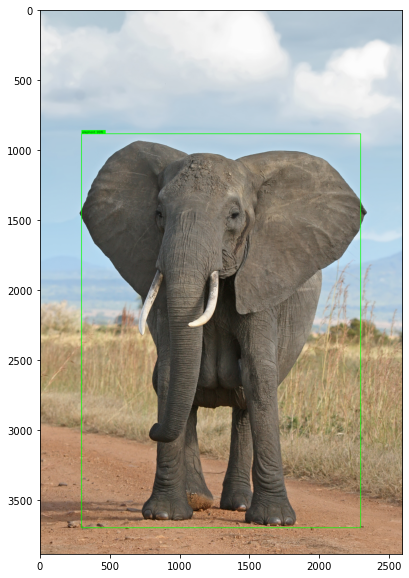

In [126]:
# Test the model on the elephant image.
image_np = np.array(Image.open('data/elephant.jpg'))
detections = detect_objects_on_image(image_np, model)
image_with_detections = draw_detections_on_image(image_np, detections, labels)
plt.figure(figsize=(10, 10))
plt.imshow(image_with_detections)

In [127]:
def plot(images, titles, subtitle=None, figsize=(8, 8)):
        
    cols = len(images)
    fig, axs = plt.subplots(1, cols, figsize=(cols * figsize[0], figsize[1]))
    if len(images) == 1:
        axs = [axs]
    if subtitle is not None:
        fig.suptitle(subtitle, fontsize=16)
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axs[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

In [100]:
def calculate_differencing(prev_f, f, vis=False):
    # Calculate the difference between the previous and the current frame.
    diff = cv2.absdiff(prev_f, f)
    if vis:
        plot([diff], ['diff'])
    return diff

#### Calculation of granulation using the simplest method. The granulated frame is the same size as the original image.

In [113]:
def granulation(image, window_size=WINDOW_SIZE, vis=False):
    height, width = image.shape[:2]
    granules = np.zeros_like(image)
    for j in range(0, height, window_size):
        for i in range(0, width, window_size):
            granule = image[j : min(j+window_size, height), i:min(i+window_size, width)]
            granules[j : min(j+window_size, height), i:min(i+window_size, width)] = np.mean(granule)

    if vis:
        plot([image, granules], ['Original', 'Granulated'], subtitle='Granulation')
        
    return granules

#### Calculate the threshold by obtaining the minimum sum of ROB and RBT

In [107]:
def compute_threshold(image):
    height, width = image.shape[:2]
    width_add = 1 if width % WINDOW_SIZE != 0 else 0
    height_add = 1 if height % WINDOW_SIZE != 0 else 0
    granule_image = [[None for _ in range(width // WINDOW_SIZE+width_add)] for _ in range(height // WINDOW_SIZE+height_add)]

    for j in range(0, height, WINDOW_SIZE):
        for i in range(0, width, WINDOW_SIZE):
            granule = image[j:min(j+WINDOW_SIZE, height), i:min(i+WINDOW_SIZE, width)]
            granule_image[j//WINDOW_SIZE][i//WINDOW_SIZE] = granule

    R_OT_best = 1
    R_BT_best = 1
    T_best = 0
    for T in range(30, 70, 5):
        O_T_lower = []
        O_T_upper = []
        B_T_lower = []
        B_T_upper = []
        for row in granule_image:
            for granule in row:
                granule_greater_T = granule > T
                granule_less_T = granule < T
                if len(granule_greater_T) > 1:
                    if np.all(granule_greater_T):
                        O_T_lower.append(granule)
                    if np.any(granule_greater_T):
                        O_T_upper.append(granule)
                if len(granule_less_T):
                    if np.all(granule_less_T):
                        B_T_lower.append(granule)
                    if np.any(granule_less_T):
                        B_T_upper.append(granule)
        R_OT = 1 - len(O_T_lower) / len(O_T_upper)
        R_BT = 1 - len(B_T_lower) / len(B_T_upper)
        if R_OT + R_BT < R_OT_best +  R_BT_best:
            R_OT_best = R_OT
            R_BT_best = R_BT
            T_best = T
        # print('R_OT:', R_OT, '   R_BT:', R_BT, '   T:', T)
    return R_OT_best, R_BT_best, T_best

#### Calculating an upper background approximation by checking if any pixel in the granule is below this threshold

In [115]:
def upper_background_approximation(gf, frame, vis=False):    
    _, _, th = compute_threshold(frame)
    height, width = gf.shape[:2]
    
    ub = np.zeros_like(gf)
    
    for i in range(0, height, WINDOW_SIZE):
        for j in range(0, width, WINDOW_SIZE):
            granule = gf[i:min(i+WINDOW_SIZE, height), j:min(j+WINDOW_SIZE, width)]
            if np.any(granule < th):
                ub[i:min(i+WINDOW_SIZE, height), j:min(j+WINDOW_SIZE, width)] = 255
    if vis:
        print("Threshold T:", th)
        plot([ub], ['Upper background approximation'])

    return ub

#### Calculating the lower background approximation by subtracting the intersection of the upper background approximation and the difference between frames

In [116]:
def granulated_background_approximation(u_b, d, window_size=WINDOW_SIZE, vis=False):
    intersection = np.zeros_like(u_b)
    height, width = d.shape[:2]

    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            if np.all(d[i:min(i+window_size, height), j:min(j+window_size, width)] > 0) and np.all(u_b[i:min(i+window_size, height), j:min(j+window_size, width)] == 255):
                intersection[i:min(i+window_size, height), j:min(j+window_size, width)] = 255
                
    BG = u_b - intersection
    
    if vis:
        plot([u_b, intersection, BG], ['Upper background', 'Intersection', 'Background'], subtitle='Background approximation')
        
    return BG

#### Currently uses the loaded SSD model for object detection. Should use GCNN model: SSD + granular layer

In [117]:
def recognition_of_static_background_objects(img, model=model):
    image_np = np.array(img)
    detections = detect_objects_on_image(image_np, model)
    return detections

In [118]:
def visualise_static_objects(frame, detections, labels=labels):
    image_np = np.array(frame)
    image_with_detections = draw_detections_on_image(image_np, detections, labels)
    plt.figure(figsize=(25, 25))
    plt.imshow(image_with_detections)

#### Compute the granulated object model: Ob = ft - Bg. 
Where:
- Ob: granulated_object_approximation
- ft: current frame
- Bg: granulated_background_approximation

In [119]:
def granulated_object_approximation(frame, BG, window_size=WINDOW_SIZE, vis=False):
    OB = np.zeros_like(frame)
    height, width = frame.shape[:2]

    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            if np.all(BG[i:min(i+window_size, height), j:min(j+window_size, width)] != 255):
                OB[i:min(i+window_size, height), j:min(j+window_size, width)] = frame[i:min(i+window_size, height), j:min(j+window_size, width)]
    if vis:
        plot([frame, OB], ['Original', 'Object'], subtitle='Object approximation')
    return OB

TODOS should be clear after analyze fig4 from: s00521-019-04200-1 (page 8 from our main paper).

**TODO (1)**
Create model with granular layer.

**TODO (2)**
Create the other method of granulation: the quad tree decomposition.

**TODO (3)**
Moving object recognition

**TODO (4)**
Track the moving objects

**TODO (LAST)**
Analyse the scene with Z-measue

Processing frame: 1


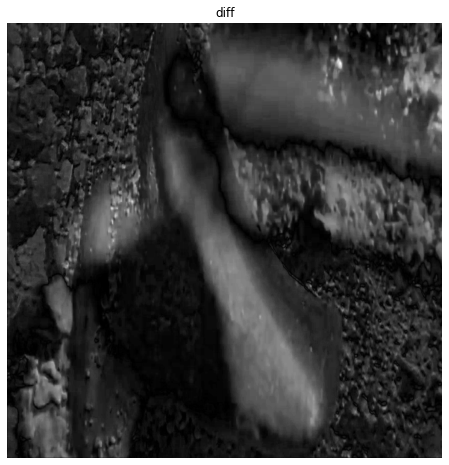

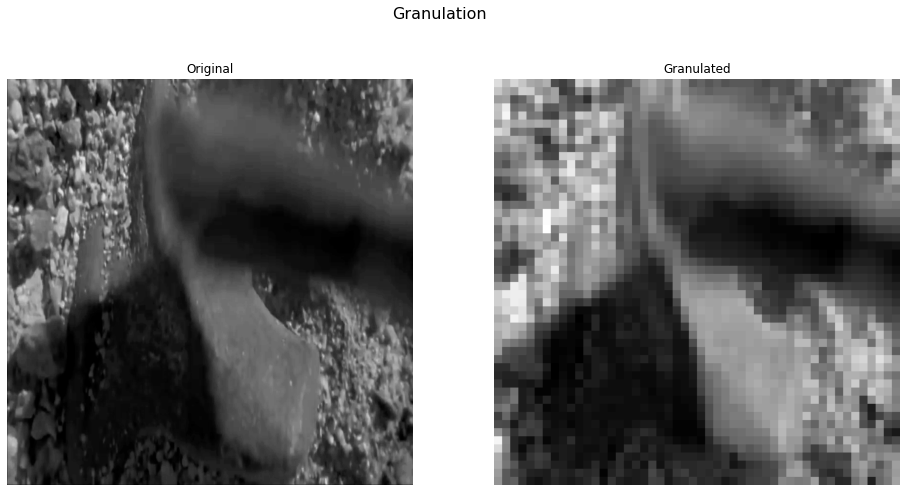

Threshold T: 30


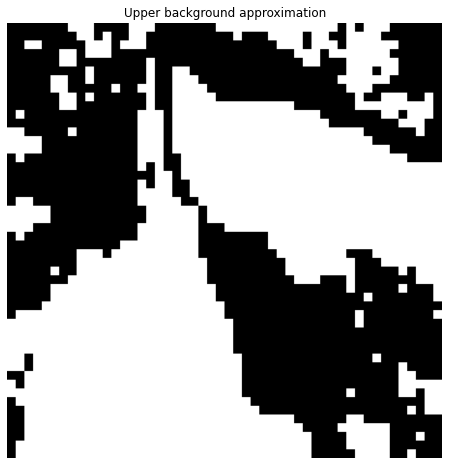

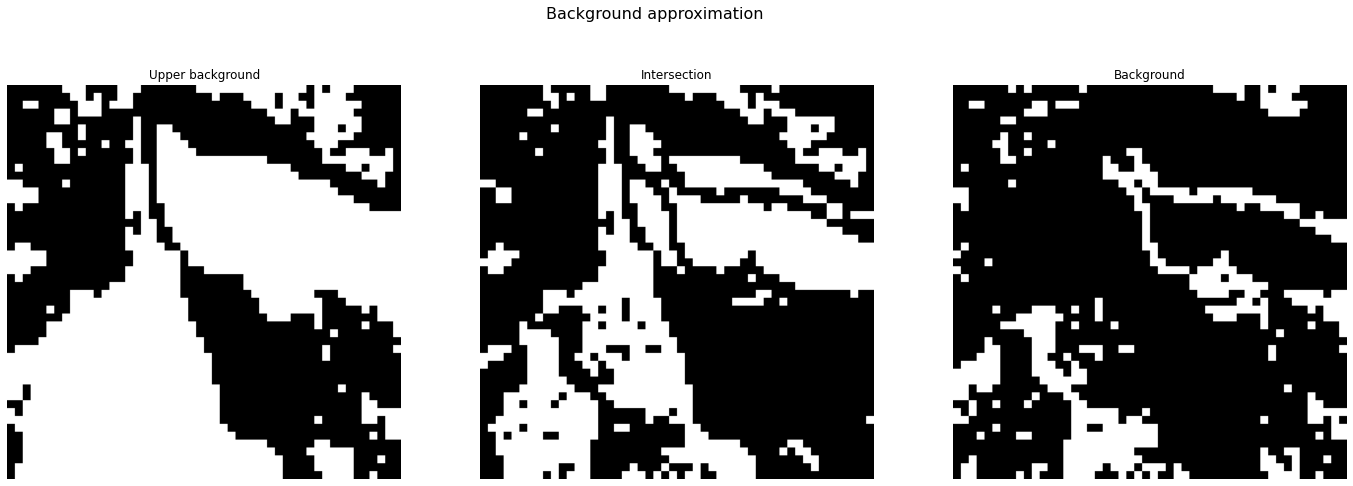

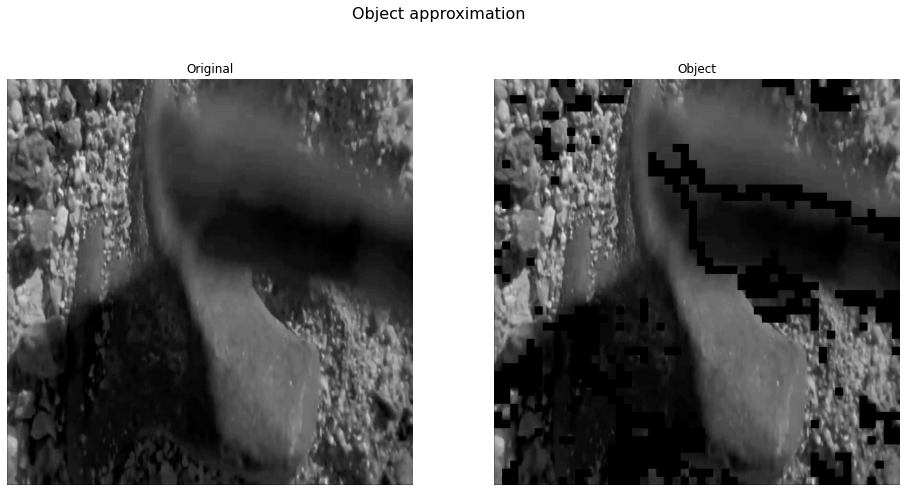

In [131]:
# Loading a video
cap = cv2.VideoCapture('data/video_jp_trim.mov')

# Processing the video frame by frame
first_frame = True
i: int = 1
while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1000, 1000))
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    if first_frame:
        first_frame = False
        prev_frame = frame
        continue
        
    if not ret:
        break

    print('Processing frame:', i)
    
    d = calculate_differencing(prev_frame, frame, vis=True)

    # TODO (2) add other method
    granulated_frame = granulation(frame, vis=True)
    # TODO (2)

    UB = upper_background_approximation(granulated_frame, frame, vis=True)

    BG = granulated_background_approximation(UB, d, vis=True)

    # TODO (1)
    # background_static_objects = recognition_of_static_background_objects(BG)

    # visualise_static_objects(frame, background_static_objects)
    # TODO (1)
    
    OB = granulated_object_approximation(frame, BG, vis=True)

    # TODO (3)
    # Moving object recognition
    # TODO (3)

    # TODO (4)
    # Track the moving objects
    # TODO (4)

    prev_frame = frame
    i += 1
    if i == 2:
        break

# Zwolnienie zasobów
cap.release()
cv2.destroyAllWindows()